In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))     

In [2]:
import os
import sys

inference_ipynb_path='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/light_sam_matting1_salient_object_detection_finetune_predict_example.ipynb'
BASE_DIR = os.path.dirname(
    os.path.dirname(os.path.dirname(inference_ipynb_path)))
sys.path.append(BASE_DIR)

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import torch
import torch.nn as nn
import torch.nn.functional as F

from simpleAICV.interactive_segmentation.models.light_segment_anything_matting.light_sam_matting1 import convformerm36_light_sam_matting1
from simpleAICV.interactive_segmentation.common import load_state_dict


sam_checkpoint = '/root/autodl-tmp/pretrained_models/light_sam_matting_train_on_salient_object_detection/convformerm36_light_sam_matting1-loss0.126.pth'

sam_model = convformerm36_light_sam_matting1(image_size=1024,         
                                             use_gradient_checkpoint=False,
                                             frozen_image_encoder=False,
                                             frozen_prompt_encoder=False,
                                             frozen_mask_decoder=False)
sam_model = sam_model.cuda()
sam_model = sam_model.eval()

load_state_dict(sam_checkpoint,sam_model)

no backbone pretrained model!
load/model weight nums:803/803
not loaded save layer weight:
[]


(1366, 2048, 3) uint8


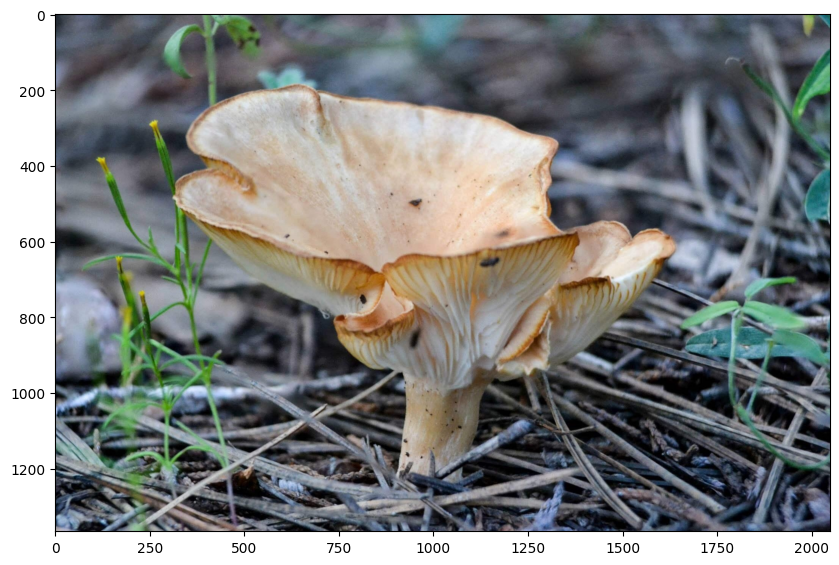

In [3]:
test_image_path='/root/code/SimpleAICV_pytorch_training_examples/13.interactive_segmentation_training/sam_predict_example/test_salient_object_detection_images/HRSOD_10113619975_0b1690a93d_k.jpg'
origin_image = cv2.imdecode(np.fromfile(test_image_path, dtype=np.uint8),
                        cv2.IMREAD_COLOR)
origin_image = cv2.cvtColor(origin_image, cv2.COLOR_BGR2RGB)
print(origin_image.shape,origin_image.dtype)

plt.figure(figsize=(10,10))
plt.imshow(origin_image)
plt.axis('on')
plt.show()

(683, 1024, 3) uint8 0.5


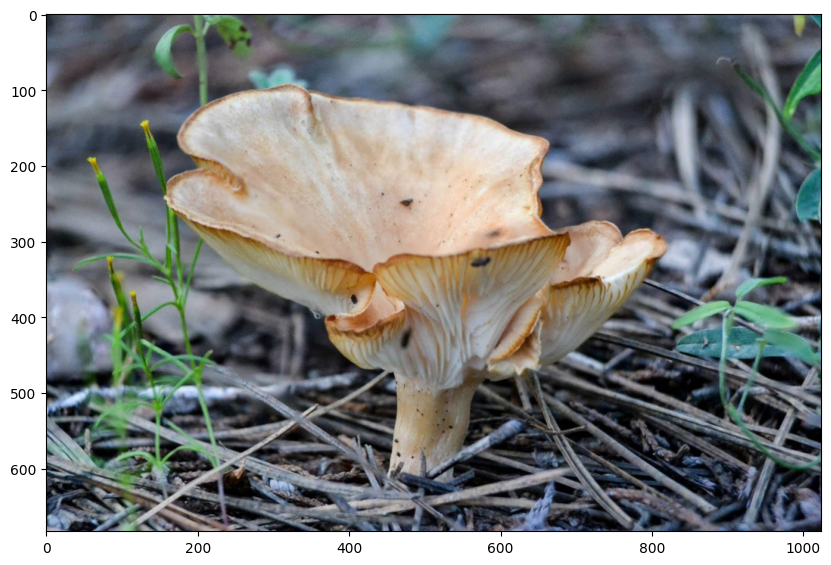

(683, 1024, 3) 2.64 -2.1179039301310043
(1024, 1024, 3) 2.64 -2.117904
torch.Size([1, 3, 1024, 1024]) tensor(2.6400, device='cuda:0') tensor(-2.1179, device='cuda:0')


In [4]:
origin_h, origin_w = origin_image.shape[0], origin_image.shape[1]
factor = 1024 / max(origin_h, origin_w)
resize_h, resize_w = int(round(origin_h * factor)), int(
    round(origin_w * factor))
resized_image = cv2.resize(origin_image, (resize_w, resize_h))
print(resized_image.shape,resized_image.dtype,factor)

plt.figure(figsize=(10, 10))
plt.imshow(resized_image)
plt.axis('on')
plt.show()

mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]
norm_image = (resized_image - mean) / std
print(norm_image.shape,np.max(norm_image),np.min(norm_image))

padded_img = np.zeros((max(resize_h, resize_w), max(resize_h, resize_w), 3),
                        dtype=np.float32)
padded_img[:resize_h, :resize_w, :] = norm_image
print(padded_img.shape,np.max(padded_img),np.min(padded_img))


padded_img = torch.tensor(padded_img).float().cuda().permute(2, 0, 1).unsqueeze(0)
print(padded_img.shape,torch.max(padded_img),torch.min(padded_img))

(1, 2) (1, 1)
(1, 3)


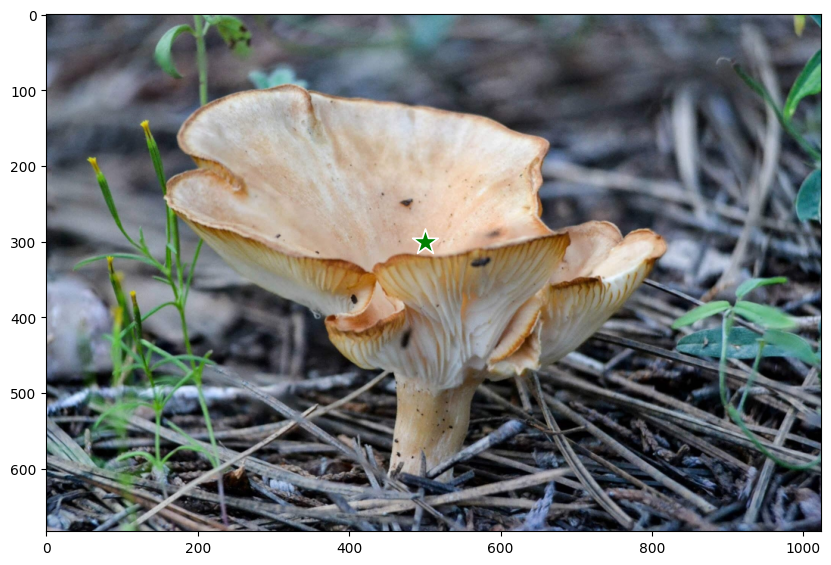

In [5]:
input_point = np.array([[1000, 600]])*factor
# if positive point, input label = 1 ,elif negative point, input label = 0
input_label = np.array([[1]])
print(input_point.shape,input_label.shape)

prompt_point=np.concatenate([input_point,input_label],axis=1)
print(prompt_point.shape)

plt.figure(figsize=(10,10))
plt.imshow(resized_image)
show_points(input_point, input_label[0], plt.gca())
plt.axis('on')
plt.show()

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 1, 3]) torch.float32 torch.float32
(1024, 1024) () 0.9915292
(683, 1024, 3) (683, 1024, 1) 255.0 0.0 1.0 0.0
(683, 1024, 3) 255.0 0.0


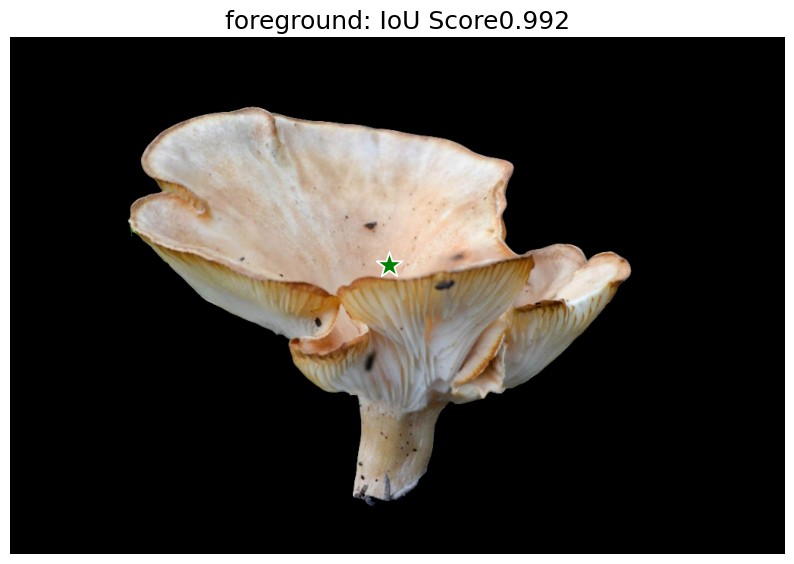

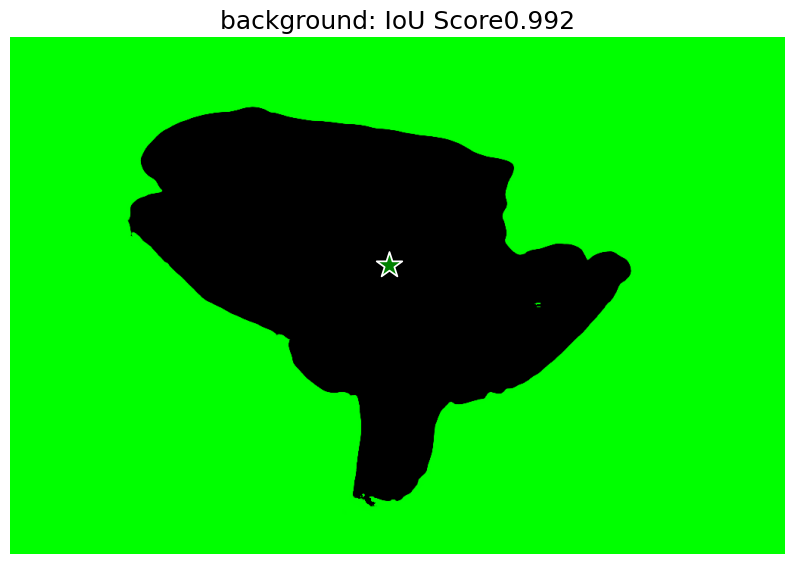

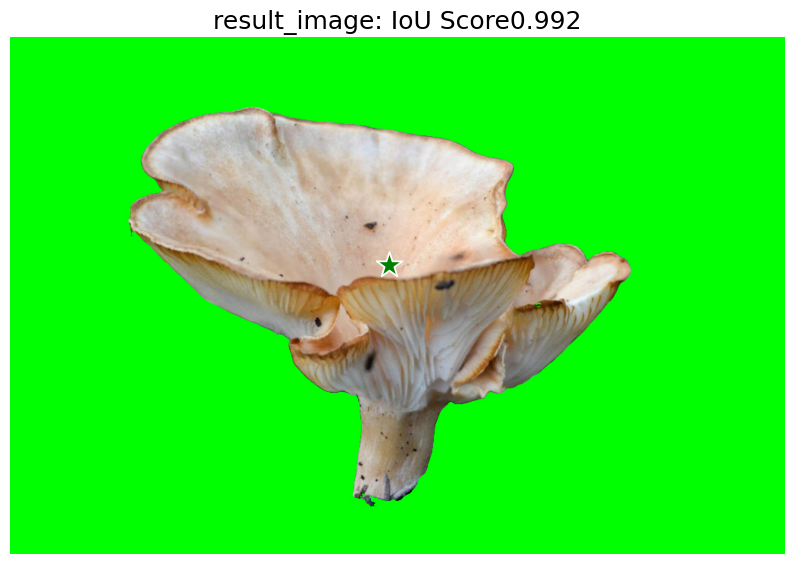

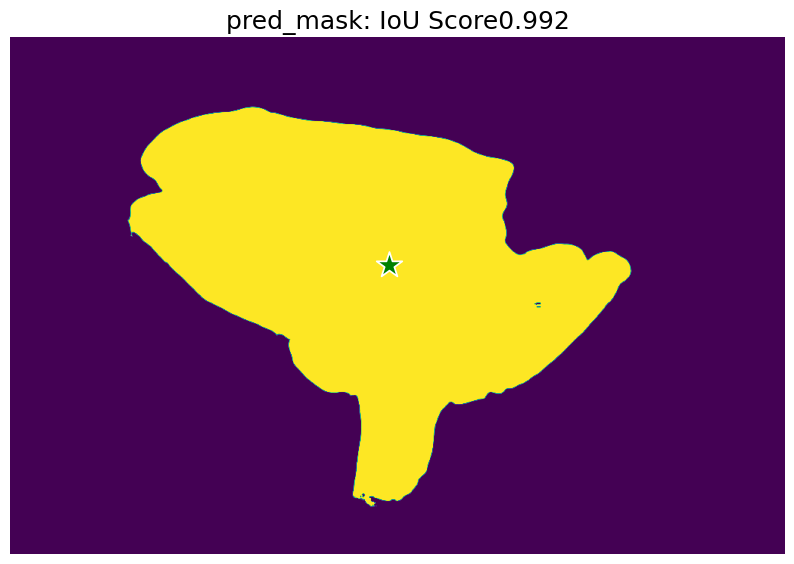

In [6]:
input_prompt_point = torch.tensor(np.expand_dims(prompt_point,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_point.shape,padded_img.dtype,input_prompt_point.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':input_prompt_point,
                'prompt_box':None,
                'prompt_mask':None}

with torch.no_grad():
    batch_masks_global_preds, batch_masks_local_preds, batch_masks_fused_preds, batch_iou_preds = sam_model(batch_images, batch_prompts, mask_out_idxs=[0, 1, 2, 3])
    masks,iou_preds = batch_masks_fused_preds[0][0], batch_iou_preds[0][0]
    pred_mask = masks.cpu().numpy()
    pred_iou = iou_preds.cpu().numpy()
print(pred_mask.shape,pred_iou.shape,pred_iou)

show_image = resized_image.astype(np.float32)
pred_mask = pred_mask[:show_image.shape[0],:show_image.shape[1]]
pred_mask = np.expand_dims(pred_mask, axis=-1)
print(show_image.shape,pred_mask.shape,np.max(show_image),np.min(show_image),np.max(pred_mask),np.min(pred_mask))
# 创建绿色背景
green_background = np.zeros_like(show_image,dtype=np.float32)
green_background[:, :] = [0, 255, 0]  # RGB格式
print(green_background.shape,np.max(green_background),np.min(green_background))
# 得到前景区域和背景区域并合并
foreground = show_image * pred_mask
background = green_background * (1 - pred_mask)
result_image = foreground + background

foreground = foreground.astype(np.uint8)
background = background.astype(np.uint8)
result_image = result_image.astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(foreground)
show_points(input_point, input_label[0], plt.gca())
plt.title(f"foreground: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(background)
show_points(input_point, input_label[0], plt.gca())
plt.title(f"background: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(result_image)
show_points(input_point, input_label[0], plt.gca())
plt.title(f"result_image: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(pred_mask)
show_points(input_point, input_label[0], plt.gca())
plt.title(f"pred_mask: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

torch.Size([1, 3, 1024, 1024]) torch.Size([1, 4]) torch.float32 torch.float32
(1024, 1024) () 0.99184614
(683, 1024, 3) (683, 1024, 1) 255.0 0.0 1.0 0.0
(683, 1024, 3) 255.0 0.0


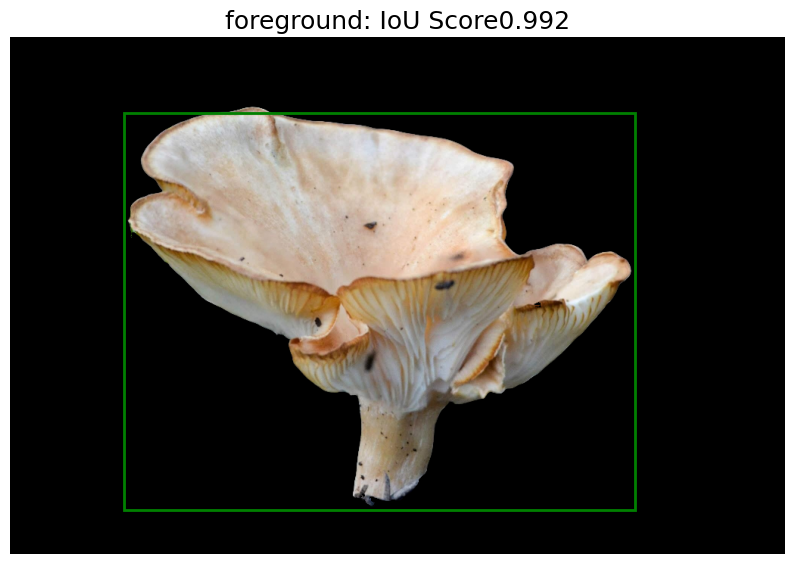

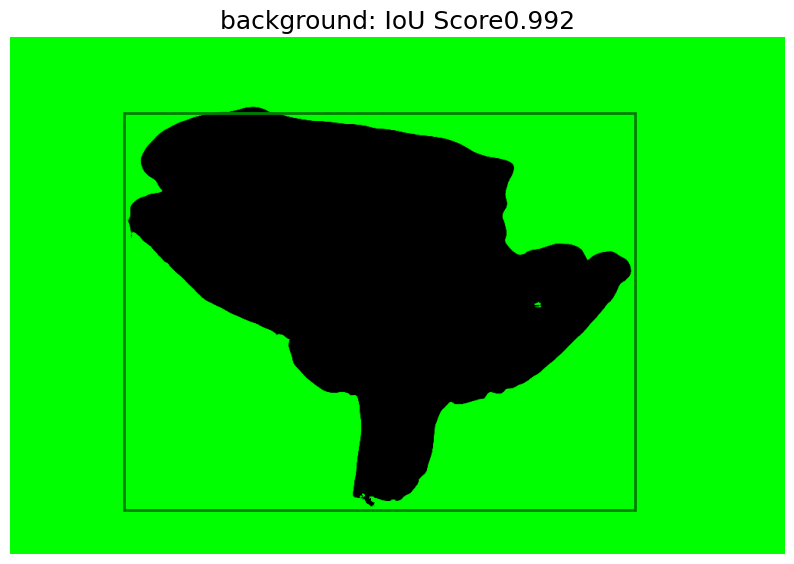

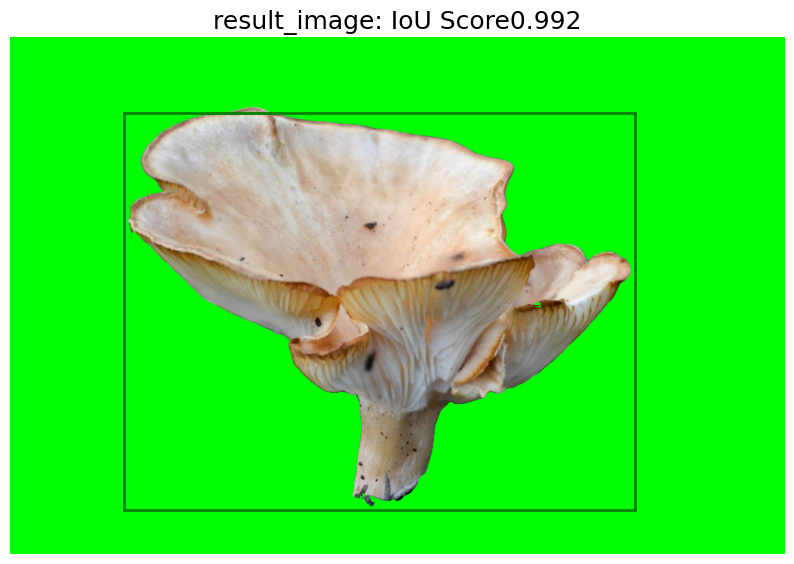

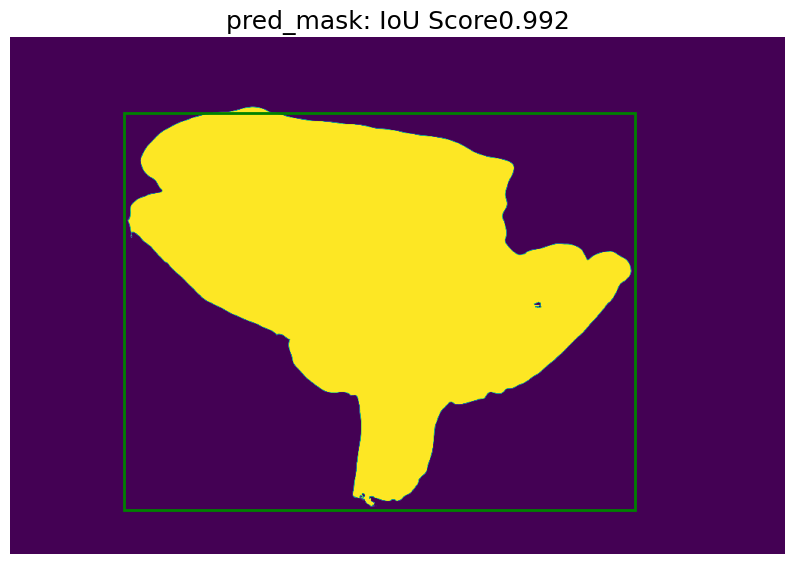

In [7]:
input_box = np.array([300, 200, 1650, 1250])*factor

input_prompt_box = torch.tensor(np.expand_dims(input_box,axis=0)).float().cuda()
print(padded_img.shape,input_prompt_box.shape,padded_img.dtype,input_prompt_box.dtype)

batch_images = padded_img.clone()
batch_prompts = {'prompt_point':None,
                'prompt_box':input_prompt_box,
                'prompt_mask':None}

with torch.no_grad():
    batch_masks_global_preds, batch_masks_local_preds, batch_masks_fused_preds, batch_iou_preds = sam_model(batch_images, batch_prompts, mask_out_idxs=[0, 1, 2, 3])
    masks,iou_preds = batch_masks_fused_preds[0][0], batch_iou_preds[0][0]
    pred_mask = masks.cpu().numpy()
    pred_iou = iou_preds.cpu().numpy()
print(pred_mask.shape,pred_iou.shape,pred_iou)

show_image = resized_image.astype(np.float32)
pred_mask = pred_mask[:show_image.shape[0],:show_image.shape[1]]
pred_mask = np.expand_dims(pred_mask, axis=-1)
print(show_image.shape,pred_mask.shape,np.max(show_image),np.min(show_image),np.max(pred_mask),np.min(pred_mask))
# 创建绿色背景
green_background = np.zeros_like(show_image,dtype=np.float32)
green_background[:, :] = [0, 255, 0]  # RGB格式
print(green_background.shape,np.max(green_background),np.min(green_background))
# 得到前景区域和背景区域并合并
foreground = show_image * pred_mask
background = green_background * (1 - pred_mask)
result_image = foreground + background

foreground = foreground.astype(np.uint8)
background = background.astype(np.uint8)
result_image = result_image.astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(foreground)
show_box(input_box, plt.gca())
plt.title(f"foreground: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(background)
show_box(input_box, plt.gca())
plt.title(f"background: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(result_image)
show_box(input_box, plt.gca())
plt.title(f"result_image: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(pred_mask)
show_box(input_box, plt.gca())
plt.title(f"pred_mask: IoU Score{pred_iou:.3f}", fontsize=18)
plt.axis('off')
plt.show()